# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлению возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, не дописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
import time
import numpy
import pandas
import seaborn
from string import punctuation
import matplotlib.pyplot as matplt
from collections import Counter, OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as nnf
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

seaborn.set_theme(style='whitegrid', font_scale=1.3, palette='Set2')

import torchtext
from torchtext.data.utils import get_tokenizer

import warnings

warnings.filterwarnings("ignore")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
device

OSError: /home/ntheme/anaconda3/envs/PyHome/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 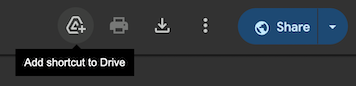

Скачаем данные для обучения и тестирования:

In [2]:
dataset = pandas.read_csv('salary_dataset.csv', delimiter=',')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [3]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation) + [" "]  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [4]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for i, text in enumerate(dataset["FullDescription"]):
    counter.update(
        token.lower()
        for token in tokenizer(text)
        if token.lower() not in stop_words and token.lower() not in punc
    )

MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[('experience', 348582),
 ('role', 238739),
 ('work', 228191),
 ('team', 218866),
 ('business', 216518),
 ('skills', 192329),
 ('working', 181823),
 ('within', 177727),
 ('sales', 170659),
 ('client', 161064)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [5]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab_cur):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab_cur.append_token(special_token)
    vocab_cur.set_default_index(vocab_cur[unk_token])
    UNK_IDX = vocab_cur[unk_token]
    PAD_IDX = vocab_cur[pad_token]
    return vocab_cur, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [6]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, targets):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) targets (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = targets

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [7]:
def pad_collate(batch_cur):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts_c, target_c = zip(*batch_cur)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(txt) for txt in texts_c]
    target_c = torch.FloatTensor(target_c)

    # Дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target_c

Токенизируем текст, а таргет переведем во `float`.

In [8]:
tokens = [vocab(tokenizer(txt)) for txt in dataset["FullDescription"]]
target = [float(val) for val in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  25000, 25000, 25000, 146, 21, 25000, 25000, 25000, 25000, 38, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  25000, 9, 25000, 15, 25000, 25000, 407, 171, 130, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [9]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(tokens, target)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(numpy.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(numpy.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на масштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1122, 0.1641, 0.159, ...


Сформируйте даталоадеры для обучения и валидации.

In [10]:
BATCH_SIZE = 128  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [11]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
            self,
            num_tokens_cur,
            emb_size=512,
            rnn_num_units=64,
            num_layers=1,
            dropout=0.0,
            output_dim=1
    ):
        """
        Параметры.
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) num_layers - количество слоёв LSTM
        5) dropout - вероятность исключения нейронов
        6) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens_cur, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.regressor = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        emb = self.emb(x)
        _, (h_state, _) = self.rnn(emb)

        predictions = self.regressor(h_state[h_state.shape[0] - 1])
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [12]:
def mse(predictions_cur, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) predictions_cur — предсказания модели,
    2) y — истинные значения таргета.
    """

    return nnf.mse_loss(predictions_cur, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [13]:
def train(model_cur, iterator, optimizer_cur, criterion_cur, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model_cur — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer_cur — класс метода оптимизации,
    4) criterion_cur — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model_cur.train()

    for batch_cur in iterator:
        optimizer_cur.zero_grad()

        texts, labels = batch_cur
        texts, labels = texts.to(device), labels.to(device).squeeze(1)

        predictions = model_cur(texts).squeeze(1)
        loss = criterion_cur(predictions, labels.float())
        acc = mse(predictions, labels)

        loss.backward()
        optimizer_cur.step()
        epoch_loss += loss.item()
        epoch_mse += acc.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model_cur, iterator, criterion_cur, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model_cur — модель,
    2) iterator — итератор датасета,
    3) criterion_cur — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model_cur.eval()

    with torch.no_grad():
        for batch_cur in iterator:
            texts, labels = batch_cur
            texts, labels = texts.to(device), labels.to(device).squeeze(1)

            predictions = model_cur(texts).squeeze(1)
            loss = criterion_cur(predictions, labels.float())
            acc = mse(predictions, labels)

            epoch_loss += loss.item()
            epoch_mse += acc.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_minimals = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_minimals * 60))
    return elapsed_minimals, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [14]:
def visualize_epoch(loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """

    # Отобразим графики лоссов
    matplt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    matplt.subplot(1, 3, 1)
    matplt.plot(train_loss_history)
    matplt.title("Train Loss")
    matplt.xlabel("Номер батча")
    matplt.subplot(1, 3, 2)
    matplt.plot(val_loss_history, color="tab:orange")
    matplt.title("Valid Loss")
    matplt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    matplt.subplot(1, 3, 3)
    matplt.plot(train_mse_history, label="Train")
    matplt.plot(val_mse_history, label="Valid")
    matplt.legend()
    matplt.title("MSE")
    matplt.xlabel("Номер эпохи")
    matplt.show()


def training_loop(model_instance, optimizer_cur, criterion_cur, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer_cur,
            criterion_cur,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion_cur, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

            # Посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_minimals, epoch_secs = epoch_time(start_time, end_time)
        print(
            f"Номер эпохи: {epoch + 1:02} | MSE Train: {train_mse:.4f} | MSE Valid: {valid_mse:.4f} | Время обучения эпохи: {epoch_minimals}m {epoch_secs}s")

        # Визуализируем результаты эпохи
        if epoch == n_epochs - 1:
            visualize_epoch((train_loss_history, val_loss_history),
                            (train_mse_history, val_mse_history))

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

- Определим функцию, выводящую информацию о созданных моделях:

In [15]:
def print_summary(model_par, rate_par, idx):
    """
    Функция для вывода сводной информации по нейросетям.
    :param model_par: (list) модель
    :param rate_par: (list) шаг обучения
    :param idx: (int) номер модели
    """
    print("=" * 20 + f"  Модель {idx}  " + "=" * 20)
    print(model_par)
    print(f"Шаг обучения: {rate_par}")
    print("=" * 52)
    print()

- Создадим несколько моделей с разными параметрами, посмотрим на них и обучим. Разделил на несколько частей кода, так как модели не влезали в оперативную память

- Создаю и обучаю 1-ю модель

====================  Модель 1  ====================
SimpleRNNRegressor(
  (emb): Embedding(25002, 128, padding_idx=25001)
  (rnn): LSTM(128, 256, batch_first=True)
  (regressor): Linear(in_features=256, out_features=1, bias=True)
)
Шаг обучения: 0.005

Номер эпохи: 01 | MSE Train: 0.0083 | MSE Valid: 0.0082 | Время обучения эпохи: 1m 0s
Номер эпохи: 02 | MSE Train: 0.0082 | MSE Valid: 0.0084 | Время обучения эпохи: 1m 0s
Номер эпохи: 03 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 1m 1s
Номер эпохи: 04 | MSE Train: 0.0083 | MSE Valid: 0.0083 | Время обучения эпохи: 1m 1s
Номер эпохи: 05 | MSE Train: 0.0084 | MSE Valid: 0.0084 | Время обучения эпохи: 1m 1s
Номер эпохи: 06 | MSE Train: 0.0083 | MSE Valid: 0.0084 | Время обучения эпохи: 1m 1s
Номер эпохи: 07 | MSE Train: 0.0083 | MSE Valid: 0.0084 | Время обучения эпохи: 1m 1s
Номер эпохи: 08 | MSE Train: 0.0083 | MSE Valid: 0.0083 | Время обучения эпохи: 1m 1s
Номер эпохи: 09 | MSE Train: 0.0084 | MSE Valid: 0.0083 | 

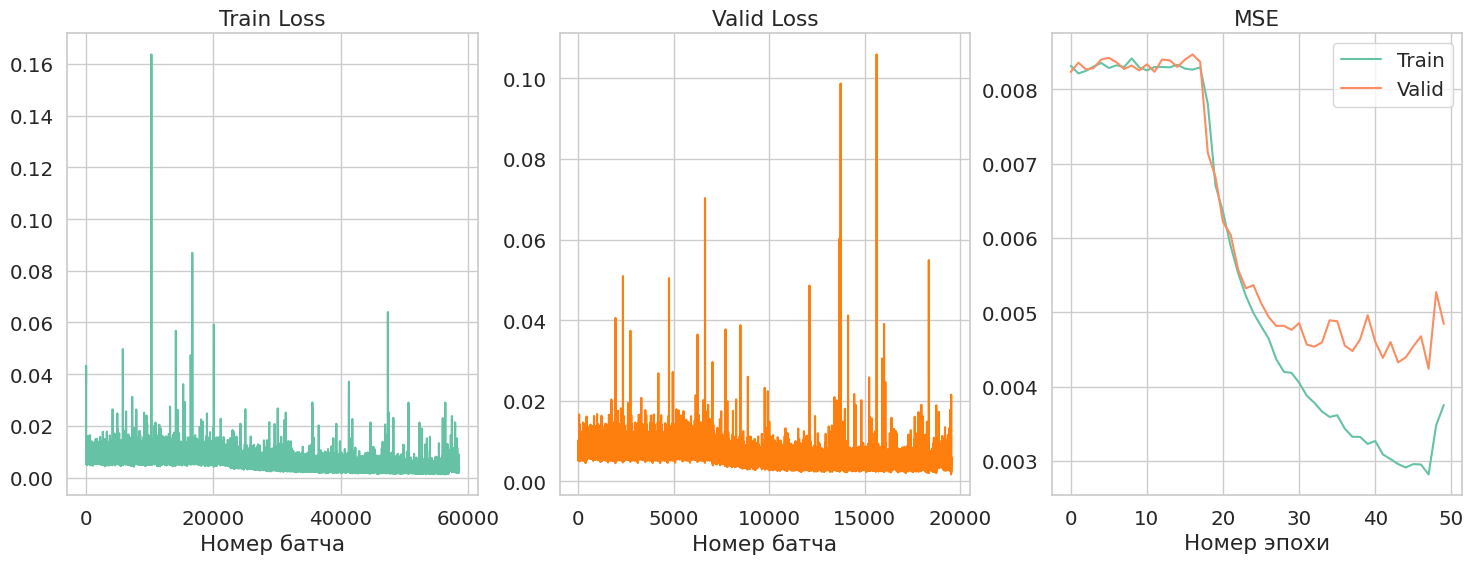

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=128, rnn_num_units=256, num_layers=1, dropout=0.0).to(
    device)
rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

print_summary(model, rate, 1)
training_loop(model, optimizer, nn.MSELoss(), n_epochs=50)
torch.save(model.state_dict(), "model_1.pt")

- Создаю и обучаю 2-ю модель

====================  Модель 2  ====================
SimpleRNNRegressor(
  (emb): Embedding(25002, 64, padding_idx=25001)
  (rnn): LSTM(64, 128, batch_first=True)
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)
Шаг обучения: 0.005

Номер эпохи: 01 | MSE Train: 0.0083 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 34s
Номер эпохи: 02 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 34s
Номер эпохи: 03 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 33s
Номер эпохи: 04 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 32s
Номер эпохи: 05 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 31s
Номер эпохи: 06 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 31s
Номер эпохи: 07 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 31s
Номер эпохи: 08 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 31s
Номер эпохи: 09 | MSE Train: 0.0082 | MSE Valid: 0.0

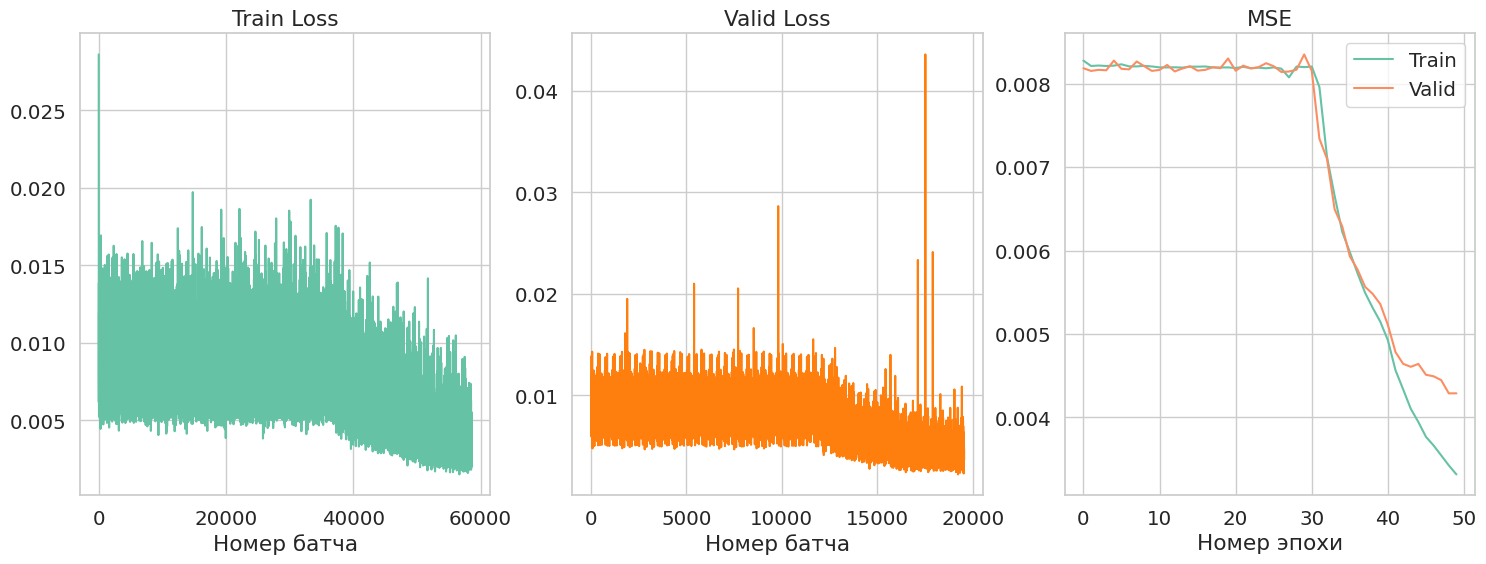

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=128, num_layers=1, dropout=0.0).to(
    device)
rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

print_summary(model, rate, 2)
training_loop(model, optimizer, nn.MSELoss(), n_epochs=50)
torch.save(model.state_dict(), "model_2.pt")

- Создаю и обучаю 3-ю модель

====================  Модель 3  ====================
SimpleRNNRegressor(
  (emb): Embedding(25002, 64, padding_idx=25001)
  (rnn): LSTM(64, 64, batch_first=True)
  (regressor): Linear(in_features=64, out_features=1, bias=True)
)
Шаг обучения: 0.007

Номер эпохи: 01 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 16s
Номер эпохи: 02 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 14s
Номер эпохи: 03 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 13s
Номер эпохи: 04 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 13s
Номер эпохи: 05 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 14s
Номер эпохи: 06 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 14s
Номер эпохи: 07 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 14s
Номер эпохи: 08 | MSE Train: 0.0082 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 13s
Номер эпохи: 09 | MSE Train: 0.0082 | MSE Valid: 0.008

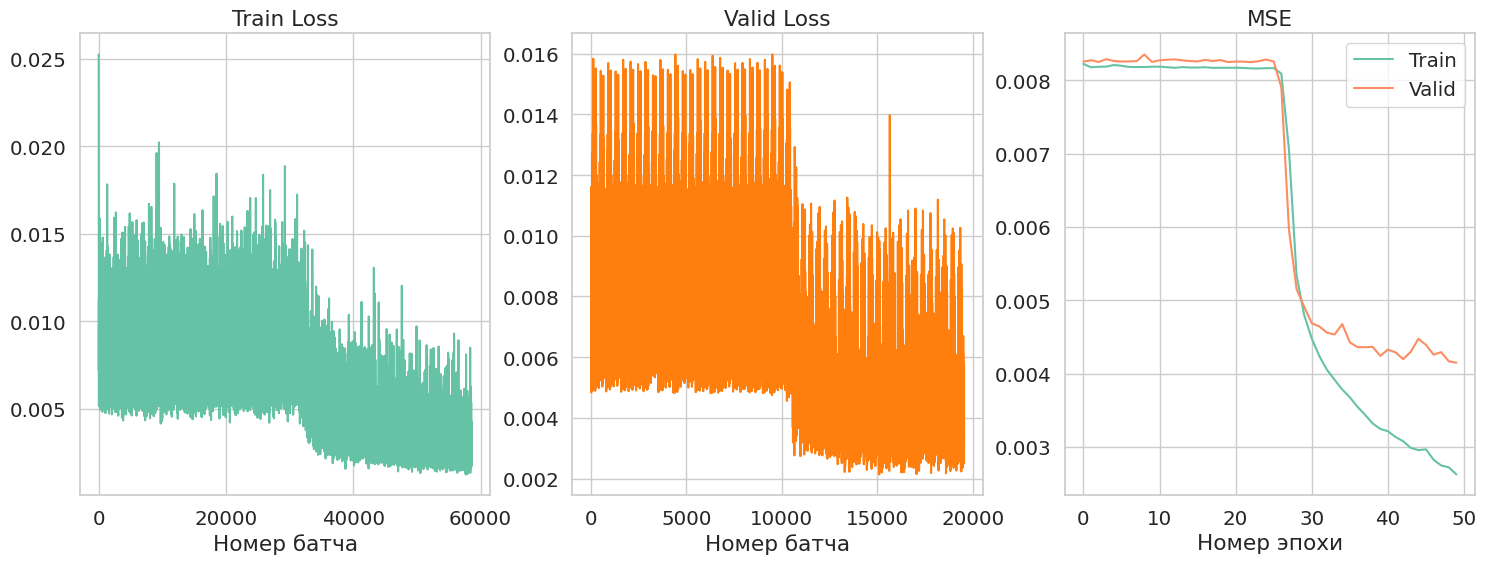

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=1, dropout=0.0).to(
    device)
rate = 0.007
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

print_summary(model, rate, 3)
training_loop(model, optimizer, nn.MSELoss(), n_epochs=50)
torch.save(model.state_dict(), "model_3.pt")

- Создаю и обучаю 4-ю модель

====================  Модель 4  ====================
SimpleRNNRegressor(
  (emb): Embedding(25002, 64, padding_idx=25001)
  (rnn): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=64, out_features=1, bias=True)
)
Шаг обучения: 0.005

Номер эпохи: 01 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 02 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 03 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 04 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 05 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 06 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 07 | MSE Train: 0.0082 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 22s
Номер эпохи: 08 | MSE Train: 0.0077 | MSE Valid: 0.0059 | Время обучения эпохи: 0m 22s
Номер эпохи: 09 | MSE Train

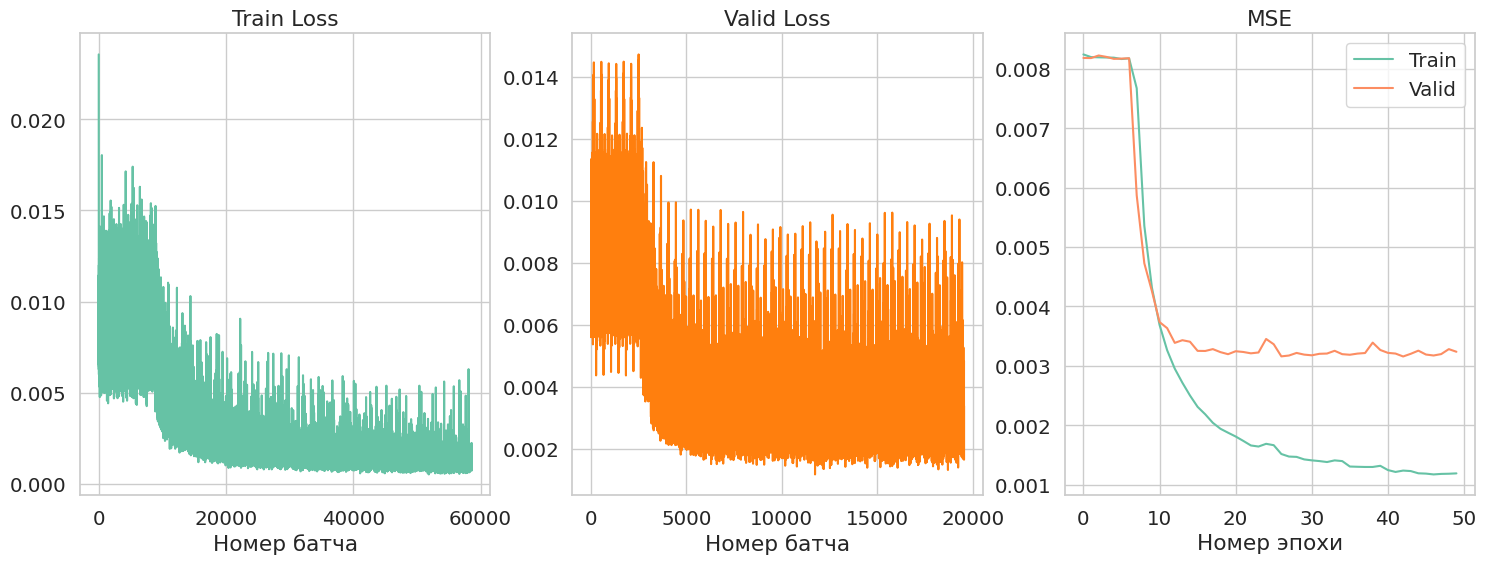

In [16]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=2, dropout=0.2).to(
    device)
rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

print_summary(model, rate, 4)
training_loop(model, optimizer, nn.MSELoss(), n_epochs=50)
torch.save(model.state_dict(), "model_4.pt")

- Создаю и обучаю 5-ю модель, затем сохраняю ее параметры в файл

====================  Модель 5  ====================
SimpleRNNRegressor(
  (emb): Embedding(25002, 64, padding_idx=25001)
  (rnn): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3)
  (regressor): Linear(in_features=64, out_features=1, bias=True)
)
Шаг обучения: 0.005

Номер эпохи: 01 | MSE Train: 0.0084 | MSE Valid: 0.0083 | Время обучения эпохи: 0m 24s
Номер эпохи: 02 | MSE Train: 0.0083 | MSE Valid: 0.0082 | Время обучения эпохи: 0m 23s
Номер эпохи: 03 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 24s
Номер эпохи: 04 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 23s
Номер эпохи: 05 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 24s
Номер эпохи: 06 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 27s
Номер эпохи: 07 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 23s
Номер эпохи: 08 | MSE Train: 0.0082 | MSE Valid: 0.0081 | Время обучения эпохи: 0m 23s
Номер эпохи: 09 | MSE Train

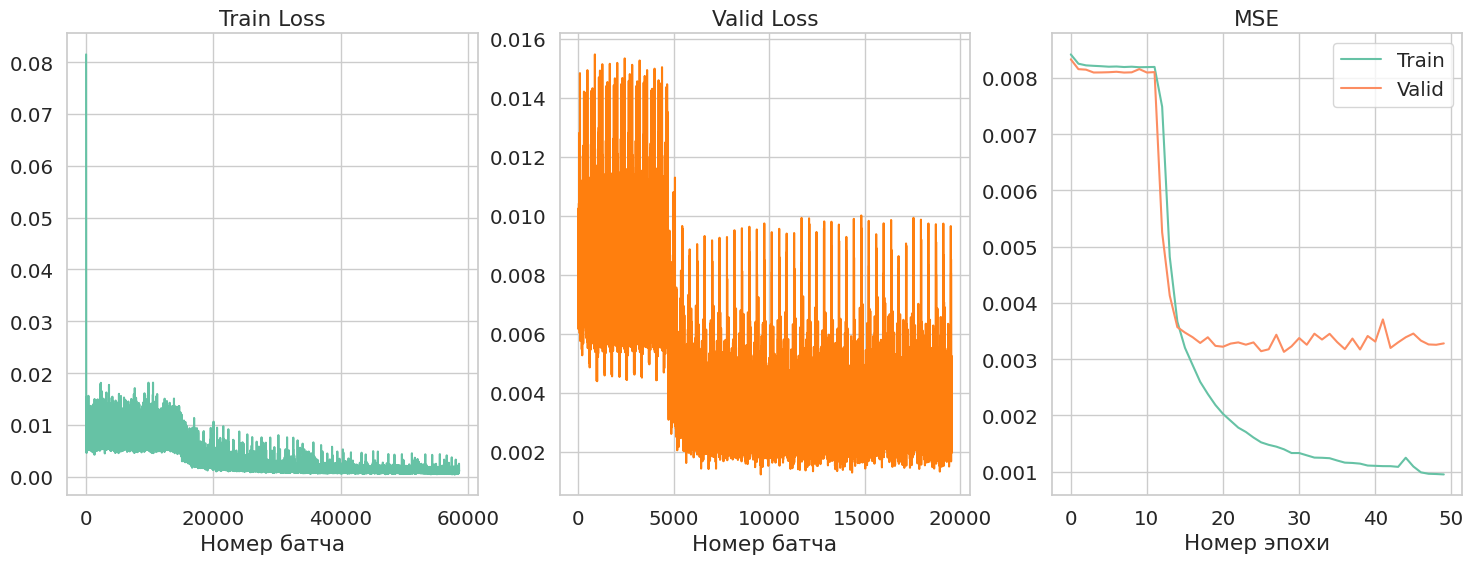

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=2, dropout=0.3).to(
    device)
rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=rate)

print_summary(model, rate, 5)
training_loop(model, optimizer, nn.MSELoss(), n_epochs=50)
torch.save(model.state_dict(), "model_5.pt")

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

- Определим функцию вывода примера работы на тестовой выборке

In [16]:
def print_test(offer_cur, prediction_cur, actual_cur):
    """
    Функция для вывода результата работы на конкретном примере

    Параметры.
    1) offer_cur: текст вакансии
    2) prediction_cur: предсказание зарплаты
    3) actual_cur: истинное значение зарплаты
    """

    test_offer = " ".join([token for token in offer_cur if token not in [unk_token, pad_token]])
    print("=" * 20)
    print(f"Предсказанное значение зарплаты: {prediction_cur.item():.1f}")
    print(f"Истинное значение зарплаты:      {actual_cur.item():.1f}")
    print(f"Описание вакансии: {test_offer}")
    print("=" * 20)
    print()

- Теперь выведем по 3 примера работы на каждой модели. Для начала определим функцию запуска модели на тестовой выборке

In [17]:
def evaluate_test(model_cur, ind):
    """Функция запуска модели на тестовой выборке и вывода результата работы

    Args:
        model_cur: модель
        ind: номер модели
    """
    print("=" * 20 + f"  Модель {ind}  " + "=" * 20)
    test_texts, test_labels = next(iter(valid_loader))
    test_texts, test_labels = test_texts.to(device), test_labels.to(device)

    with torch.no_grad():
        test_predictions = scaler.inverse_transform(model_cur(test_texts).cpu().numpy())
        test_actual = scaler.inverse_transform(test_labels.cpu().numpy())

        print("Примеры")
        indices = torch.randint(low=0, high=len(test_texts), size=(3,))
        for idx in indices:
            test_tokens = vocab.lookup_tokens(test_texts[idx].tolist())
            print_test(test_tokens, test_predictions[idx], test_actual[idx])

        acc = mse(torch.tensor(test_predictions), torch.tensor(test_actual)).item()
        print("MSE на тестовой выборке:", acc)
    print("=" * 52)
    print()

- Теперь запустим на каждой модели поочереди и выведем MSE

- Тестовый вывод и MSE 1-й модели:

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=128, rnn_num_units=256, num_layers=1, dropout=0.0).to(
    device)
model.load_state_dict(torch.load("model_1.pt"))
model.eval()

evaluate_test(model, 1)

====================  Модель 1  ====================
Примеры
Предсказанное значение зарплаты: 23023.4
Истинное значение зарплаты:      18505.0
Описание вакансии: organisation founded excellence also adventurous imaginative innovative qualities resonate like work organisation heart national cultural revolution top game challenge ensuring continues world class resource world class talent within small team role exciting opportunity secure new recurring funding individuals trusts foundations key initiatives specifically scholarships work help ensure talented individuals backgrounds develop emerging artists looking talented individual naturally curious relishes forming developing strong relationships donors levels also work senior volunteers passionate future iconic organisation anyone know would like find inspiring role please email recruitment full information pack also call office discuss inspiring role reviewed information date 4 2013 held week beginning 11 2013 search conducted behalf 

- Тестовый вывод и MSE 2-й модели:

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=128, num_layers=1, dropout=0.0).to(
    device)
model.load_state_dict(torch.load("model_2.pt"))
model.eval()

evaluate_test(model, 2)

====================  Модель 2  ====================
Примеры
Предсказанное значение зарплаты: 22165.5
Истинное значение зарплаты:      21226.0
Описание вакансии: lives better pro rata part time 17.5 hours per week recruiting leading provider employment opportunities disadvantaged people last year organisation enabled people range disabilities health conditions complex barriers work find remain employment either significant employers within business role never dull work fast paced environment tasked ensure individuals receive training skills required employment market demonstrate passion delivering highest standards service whilst working potential candidates employers match required skill sets difficulties job seekers face today challenging economy essential identify area development deliver bespoke training assist candidates employability engaging local employers build long standing relationships allow understand business deliver effective recruitment solutions opportunity demonstrate

- Тестовый вывод и MSE 3-й модели:

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=1, dropout=0.0).to(
    device)
model.load_state_dict(torch.load("model_3.pt"))
model.eval()

evaluate_test(model, 3)

====================  Модель 3  ====================
Примеры
Предсказанное значение зарплаты: 26134.6
Истинное значение зарплаты:      30000.0
Описание вакансии: exciting newly created opportunity arisen part clients exciting portfolio 2013 keen hear experience strong background delivering wide range employees within white collar industries also experience delivering training within soft skills arena order support business moving forward progressive agenda significant investment permanent role requiring candidates experience working small businesses developing meaningful lasting working relationships interested role please apply clicking link contact details specialise exclusively recruitment nationwide temporary contract permanent roles give equal priority candidate client relationships ensure deliver highly professional consultancy service times find us please visit website www.ashleykatehr.com group follow us operates provision permanent candidates provision temporary candidates

Пр

- Тестовый вывод и MSE 4-й модели:

In [18]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=2, dropout=0.2).to(
    device)
model.load_state_dict(torch.load("model_4.pt"))
model.eval()

evaluate_test(model, 4)

====================  Модель 4  ====================
Примеры
Предсказанное значение зарплаты: 31809.0
Истинное значение зарплаты:      28000.0
Описание вакансии: client premises maintain upgrade install fire alarm detection systems emergency lighting related fire systems accordance relevant codes practice legislation legislation full fire protection package offered company supply service safety equipment throughout name suggests offer complete range fire safety services types business commerce initial fire risk assessment specification installation custom solutions delivered network one largest fastest growing independent fire protection companies looking recruit additional join team support continued growth require good communication skills sound electrical background part equivalent offer excellent remuneration package working conditions fully expensed company vehicle uniform pension scheme chance join successful company

Предсказанное значение зарплаты: 36432.2
Истинное значение зар

- Тестовый вывод и MSE 5-й модели:

In [ ]:
model = SimpleRNNRegressor(num_tokens_cur=num_tokens, emb_size=64, rnn_num_units=64, num_layers=2, dropout=0.3).to(
    device)
model.load_state_dict(torch.load("model_5.pt"))
model.eval()

evaluate_test(model, 5)

====================  Модель 5  ====================
Примеры
Предсказанное значение зарплаты: 26915.8
Истинное значение зарплаты:      23040.0
Описание вакансии: tester web tester app tester applications test per hour type fantastic career opportunity experienced emerged one world leading specialist engineering production facilities highly accomplished enterprise provides vast range products services pharmaceutical automotive aerospace various industries around world candidates required produce detailed functional regression operational test plans prepare test data execute tests assist developers resolving issues ideal position would certified offer experience testing web based systems using test tracking execution tools demonstrate understanding different software development lifecycles excellent documentation skills attention detail ability communicate detailed technical issues internal business/ project teams candidates full eligibility work considered required must proficient full 

**Вывод:**
  - Увеличение количества слоев положительно влияет на точность модели
  - Выставление ненулевого dropout (вероятности, с которой не учитываем нейроны) положительно влияет на скорость обучения, и на точность предсказаний
  - Уменьшение размера пространства скрытых представлений в rnn положительно влияет на точность, спасая от переобучения. То есть, на "золотой середине" мы достигнем оптимума
  - Сильно увеличивать количество слоев плохо: не влезет в память и большое количество параметров модели сделает ее переобучаемой
  - Лучше всего справилась модель с двумя слоями вероятностью выброса нейронов 0.3 и не сильно большими размером пространства скрытых представлений в rnn и эмбеддингового пространства (последняя). Смотря на примеры можем сказать, что истинные значения довольно близки к предсказанным

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [2]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...

От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [4]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [14]:
prompt = """You are a salary prediction program that predicts the expected salary amount and the accuracy of this prediction based on the text description of the vacancy. In response to the text of the vacancy below, return the salary prediction for it and the accuracy of this prediction.
# Vacancy: This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe.
# Vacancy: Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, JavaScript, AJAX, XML, XSLT and CSS. You will be able to design/develop and maintain databases using SQL and stored producers. You will have excellent problem solving skills and able to manage projects to tight declines. This is an excellent development role with great career progression.
# Vacancy: A large secondary school in Leeds is seeking a teacher of Science for a long term position , potentially starting immediately . The school have fantastic new facilities, and are looking for an innovative, confident and dedicated practitioner, who will help them on the road to becoming Outstanding. All candidates require a recognised teaching qualification, and should be able to demonstrate recent experience in delivering Chemistry and Biology to GCSE. Academic Appointments is committed to safeguarding and promoting the welfare of children and young people. All posts are subject to an enhanced CRB check and referencing."""

batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>You are a salary prediction program that predicts the expected salary amount and the accuracy of this prediction based on the text description of the vacancy. In response to the text of the vacancy below, return the salary prediction for it and the accuracy of this prediction.
1 Vacancy: This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe.
2 Vac

- Получили следующие значения предсказаний:
  - Для 1-й: зарплата 58000, точность 0.789. Истинное значение: 55000
  - Для 2-й: зарплата 30000, точность 0.894. Истинное значение: 27500
  - Для 3-й: зарплата 52000, точность 0.642. Истинное значение: 32400

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**
- Предсказания LLAMA довольно не точны по сравнению с истинными значениями. Непонятно, как она считает точность предсказаний, есть шанс, что просто выдает случайные числа. Верить ей нельзя
- Наша модель 5 дает сильно более качественные результаты на тех же промптах

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*